# Imports

In [118]:
import re
import string
import os

from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import statsmodels.api as sm

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
# from functions import W2vVectorizer

## Obtain

In [69]:
# Open csv file with hourly American Airlines stock data

stock_ts = pd.read_csv('AAL_stock_ts.csv')

stock_ts

,Time,Price
0,1/2/2020 10:00,29.010
1,1/2/2020 11:00,28.925
2,1/2/2020 12:00,28.890
3,1/2/2020 13:00,28.870
4,1/2/2020 14:00,28.795
...,...,...
1657,3/11/2020 11:00,15.787
1658,3/11/2020 12:00,15.589
1659,3/11/2020 13:00,15.952
1660,3/11/2020 14:00,15.824


In [70]:
# Open csv file with all American Airlines tweets

aa_tweets_df = pd.read_csv('twitter_30_days.csv')

aa_tweets_df.head()

,id,datetime,text,retweets
0,1232091470154338304,Mon Feb 24 23:54:32 +0000 2020,Joining us now Beverly Bass who was the first ...,1
1,1232089893628776448,Mon Feb 24 23:48:16 +0000 2020,More @AmericanAir mechanical delays. Yo @South...,0
2,1232087057352146944,Mon Feb 24 23:37:00 +0000 2020,Check out #KidsCubsCactus for your daily dose ...,3
3,1232086687125311490,Mon Feb 24 23:35:31 +0000 2020,2 days in a row. Travel nightmares. @American...,0
4,1232086061695651840,Mon Feb 24 23:33:02 +0000 2020,Hey @AmericanAir. Making these seats smaller s...,0


## Scrub/Explore

### Stock data

In [71]:
# Set index to be time

stock_ts.set_index('Time', inplace=True, drop=False)

In [110]:
# Subset stock data for period from 1-25-2020 4:00 to 2-25-2020 0:00

stock_ts = stock_ts['1/25/2020 4:00': '2/25/2020 0:00']

In [111]:
# Plot time series data

fig = px.line(stock_ts, x='Time', y='Price', title='American Airlines Stock Price - Jan 2 - Mar 11, 2020')
fig.update_xaxes(nticks=10)
fig.show()

In [112]:
# Check time series for null values

stock_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 741 entries, 1/25/2020 4:00 to 2/25/2020 0:00
Data columns (total 2 columns):
Time     741 non-null object
Price    741 non-null float64
dtypes: float64(1), object(1)
memory usage: 17.4+ KB


In [113]:
# Plot histogram of stock prices

fig = px.histogram(stock_ts, x='Price', title='American Airlines Stock Price - Jan 2 - Mar 11, 2020')
fig.show()

Over these 2+ months, the stock price appears to have an almost bi-modal distribution.

### Tweet data

In [75]:
def clean_tweet(tweet):
    
    # Remove punctuation
    tweet = tweet.translate(string.punctuation)
    tweet = tweet.lower().split()
    
#     stemmer = SnowballStemmer("english")
#     tweet = [stemmer.stem(word) for word in tweet]
    # Remove stop words
#     tweet = [word for word in tweet if word not in stopwords_list]
    tweet = " ".join(tweet)
#   
    # Regular expressions
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", tweet)
    tweet = re.sub(r",", " ", tweet)
    tweet = re.sub(r";", " ", tweet)
    tweet = re.sub(r"\.", " ", tweet)
    tweet = re.sub(r"!", "", tweet)
    tweet = re.sub(r":", "", tweet)
    tweet = re.sub(r"\/", " ", tweet)
    tweet = re.sub(r"\^", " ", tweet)
    tweet = re.sub(r"\+", "plus", tweet)
    tweet = re.sub(r"\-", "minus", tweet)
    tweet = re.sub(r"\=", "equals", tweet)
    tweet = re.sub(r"'", "", tweet)
    
    return tweet

In [76]:
# Clean tweets in aa dataset

aa_tweets_df['clean_text'] = aa_tweets_df['text'].map(lambda x: clean_tweet(x))    

aa_tweets_df.head()

,id,datetime,text,retweets,clean_text
0,1232091470154338304,Mon Feb 24 23:54:32 +0000 2020,Joining us now Beverly Bass who was the first ...,1,joining us now beverly bass who was the first ...
1,1232089893628776448,Mon Feb 24 23:48:16 +0000 2020,More @AmericanAir mechanical delays. Yo @South...,0,more americanair mechanical delays yo south...
2,1232087057352146944,Mon Feb 24 23:37:00 +0000 2020,Check out #KidsCubsCactus for your daily dose ...,3,check out kidscubscactus for your daily dose ...
3,1232086687125311490,Mon Feb 24 23:35:31 +0000 2020,2 days in a row. Travel nightmares. @American...,0,2 days in a row travel nightmares americana...
4,1232086061695651840,Mon Feb 24 23:33:02 +0000 2020,Hey @AmericanAir. Making these seats smaller s...,0,hey americanair making these seats smaller s...


In [77]:
# Tokenize aa_tweets_df text

aa_tweets_df['tokens'] = aa_tweets_df['clean_text'].map(lambda x: word_tokenize(x))    

for token in aa_tweets_df['tokens']:
    print(token)

['joining', 'us', 'now', 'beverly', 'bass', 'who', 'was', 'the', 'first', 'female', 'captian', 'for', 'americanair', 'and', 'who', 's', 'story', 'is', 'told', 'in', 'wecomefromaway', 'broadwaygr', 'bgrseasonreveal']
['more', 'americanair', 'mechanical', 'delays', 'yo', 'southwestair', 'delta', 'you', 'up', 'this', 'platinum', 'advantage', 'is', 'about', 'to', 'bounce']
['check', 'out', 'kidscubscactus', 'for', 'your', 'daily', 'dose', 'of', 'inspiration', 'thanks', 'to', 'the', 'work', 'of', 'advocatekids', 'amp', 'americanair', 'five', 'kids', 'got', 'to', 'visit', 'the', 'cubs', 'at', 'spring', 'training', 'these', 'five', 'fans', 'are', 'all', 'patients', 'at', 'advocate', 'childrens', 'hospital', 'who', 'were', 'surprised', 'with', 'the', 'trip', 'of', 'a', 'lifetime']
['2', 'days', 'in', 'a', 'row', 'travel', 'nightmares', 'americanair', 'horrible', '2', 'days', 'in', 'a', 'row', 'you', 'have', 'canceled', 'flights', 'or', 'were', 'over', 'an', 'hour', 'late', 'causing', 'me', 'to

['1job', 'should', 'be', 'enough', 'for', 'all', 'airline', 'workers', 'including', 'the', 'thousands', 'of', 'subcontracted', 'workers', 'who', 'despite', 'being', 'essential', 'to', 'helping', 'keep', 'the', 'industry', 'inflight', 'are', 'left', 'in', 'poverty', 'as', 'airlines', 'like', 'americanair', 'delta', 'united', 'enjoy', 'booming', 'profits']
['1job', 'should', 'be', 'enough', 'for', 'all', 'airline', 'workers', 'including', 'the', 'thousands', 'of', 'subcontracted', 'workers', 'who', 'despite', 'being', 'essential', 'to', 'helping', 'keep', 'the', 'industry', 'inflight', 'are', 'left', 'in', 'poverty', 'as', 'airlines', 'like', 'americanair', 'delta', 'united', 'enjoy', 'booming', 'profits']
['1job', 'should', 'be', 'enough', 'for', 'all', 'airline', 'workers', 'including', 'the', 'thousands', 'of', 'subcontracted', 'workers', 'who', 'despite', 'being', 'essential', 'to', 'helping', 'keep', 'the', 'industry', 'inflight', 'are', 'left', 'in', 'poverty', 'as', 'airlines', 'l

['i', 'like', 'that', 'in', 'clt', 'americanair', 'puts', 'commuter', 'planes', 'in', 'e', 'and', 'connecting', 'flight', 'in', 'a', 'agent', 'in', 'a', 'said', 'walking', 'was', 'good', 'for', 'americans', 'cause', 'they', 'are', 'overweight', '18', 'minute', 'walk']
['american', 'airlines', 'has', 'an', 'empty', 'flight', 'amp', 'put', 'folks', 'in', 'last', 'row', '3', 'across', 'and', 'i', 'paid', 'for', 'these', 'seats', 'americanair', 'sucks', 'and', 'i', 'm', 'a', 'frequent', 'flyer', 'the', 'worse']
['yesterday', 'when', 'wallison', 'amp', 'i', 'got', 'to', 'the', 'airport', 'americanair', 'said', 'my', 'ticket', 'got', 'refunded', 'but', 'not', 'wallisons', 'amp', 'almost', 'didn', 't', 'catch', 'our', 'flight', 'bc', 'the', 'customer', 'service', 'lady', 'was', 'just', 'ignoring', 'us', 'thankfully', 'god', 'was', 'on', 'our', 'side', 'amp', 'we', 're', 'laying', 'on', 'the', 'beach', 'in', 'miami', 'rn']
['n274ay', 'americanair', 'aa732', 'diverted', 'into', 'dublinairport',

## Model

### Predict Labels for AA tweets using GloVe 200d classifier

Get GloVe embeddings for all of the AA tweet tokens

In [78]:
# Get vocabulary

vocabulary = set(word for tweet in aa_tweets_df.tokens for word in tweet)

len(vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(vocabulary)))

There are 20480 unique tokens in the dataset.


In [79]:
# See available files for GloVe

os.listdir("C:/Users/dougl/glove.twitter.27B/")

['glove.twitter.27B.100d.txt',
 'glove.twitter.27B.200d.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.50d.txt']

In [80]:
# Get GloVe embeddings for each word present in the vocabulary

glove = {}
with open(r'C:/Users/dougl/glove.twitter.27B/glove.twitter.27B.200d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [81]:
# Check length of glove dictionary (number of words in GloVe matched by word in corpus)

print(f'{len(glove)} of {len(vocabulary)} tokens in dataset matched in GloVe and vectorized!')

12360 of 20480 tokens in dataset matched in GloVe and vectorized!


Vectorize tweets using mean GloVe word embeddings

In [82]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        # X should be a series of lists of tokens
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [83]:
# Instantiate a mean word embedding vectorizer using glove embeddings

vectorizer = W2vVectorizer(glove)

In [84]:
# Transform tokenized tweets to glove vectors

X_unlabeled = vectorizer.transform(aa_tweets_df.tokens)

In [85]:
X_unlabeled.shape

(11090, 200)

In [86]:
# Load in variables from tweet_classification notebook and preview

%store -r X_labeled
%store -r y_labeled

In [87]:
X_labeled.head()

0                [virginamerica, what, dhepburn, said]
3    [virginamerica, its, really, aggressive, to, b...
4    [virginamerica, and, its, a, really, big, bad,...
5    [virginamerica, seriously, would, pay, 30, a, ...
9    [virginamerica, it, was, amazing, and, arrived...
Name: tokens, dtype: object

In [88]:
y_labeled.head()

0    1
3    0
4    0
5    0
9    2
Name: target, dtype: int32

In [89]:
# Vectorize X_labeled data

X_labeled = vectorizer.transform(X_labeled)

Fit a LinearSVC classifier to labeled data

In [90]:
# Instantiate classifier and fit

clf = LinearSVC(random_state=1, max_iter=10000)

In [91]:
clf.fit(X_labeled, y_labeled)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [92]:
preds = clf.predict(X_unlabeled)

In [93]:
aa_tweets_df['labels'] = preds

In [94]:
aa_tweets_df.head()

,id,datetime,text,retweets,clean_text,tokens,labels
0,1232091470154338304,Mon Feb 24 23:54:32 +0000 2020,Joining us now Beverly Bass who was the first ...,1,joining us now beverly bass who was the first ...,"[joining, us, now, beverly, bass, who, was, th...",1
1,1232089893628776448,Mon Feb 24 23:48:16 +0000 2020,More @AmericanAir mechanical delays. Yo @South...,0,more americanair mechanical delays yo south...,"[more, americanair, mechanical, delays, yo, so...",0
2,1232087057352146944,Mon Feb 24 23:37:00 +0000 2020,Check out #KidsCubsCactus for your daily dose ...,3,check out kidscubscactus for your daily dose ...,"[check, out, kidscubscactus, for, your, daily,...",0
3,1232086687125311490,Mon Feb 24 23:35:31 +0000 2020,2 days in a row. Travel nightmares. @American...,0,2 days in a row travel nightmares americana...,"[2, days, in, a, row, travel, nightmares, amer...",0
4,1232086061695651840,Mon Feb 24 23:33:02 +0000 2020,Hey @AmericanAir. Making these seats smaller s...,0,hey americanair making these seats smaller s...,"[hey, americanair, making, these, seats, small...",0


### Create 1-hr bins for tweets

In [95]:
aa_tweets_df['datetime'] = pd.to_datetime(aa_tweets_df['datetime'])

In [96]:
# Create an interval range for each hour

bins_dt = pd.date_range(start = '2020-01-25', end = '2020-02-25', freq='H')
bins_str = bins_dt.astype(str).values

labels = ['({}, {}]'.format(bins_str[i-1], bins_str[i]) for i in range(1, len(bins_str))]

In [97]:
# Create hourly bins using dataframe's datetime

aa_tweets_df['bin'] = pd.cut(aa_tweets_df['datetime'], 
                             bins=bins_dt,
                             labels=labels)

In [98]:
aa_tweets_df.tail()

,id,datetime,text,retweets,clean_text,tokens,labels,bin
11085,1220918175329673216,2020-01-25 03:55:51+00:00,#AmericanAirlines currently 4.5 hours delayed ...,1,americanairlines currently 4 5 hours delayed ...,"[americanairlines, currently, 4, 5, hours, del...",0,"(2020-01-25 03:00:00, 2020-01-25 04:00:00]"
11086,1220911582827491335,2020-01-25 03:29:39+00:00,Ouch @AmericanAir flight 380 from LGA! Very ab...,0,ouch americanair flight 380 from lga very abr...,"[ouch, americanair, flight, 380, from, lga, ve...",0,"(2020-01-25 03:00:00, 2020-01-25 04:00:00]"
11087,1220907874651688962,2020-01-25 03:14:55+00:00,"...48°F in #WashingtonDC. Oh boy, that's too h...",0,48 f in washingtondc oh boy thats too ho...,"[48, f, in, washingtondc, oh, boy, thats, too,...",1,"(2020-01-25 03:00:00, 2020-01-25 04:00:00]"
11088,1220907640248832001,2020-01-25 03:13:59+00:00,"Just flew @AmericanAir and it was the hottest,...",0,just flew americanair and it was the hottest ...,"[just, flew, americanair, and, it, was, the, h...",0,"(2020-01-25 03:00:00, 2020-01-25 04:00:00]"
11089,1220907338699354113,2020-01-25 03:12:47+00:00,Special thank you to @AmericanAir and @DFWAirp...,0,special thank you to americanair and dfwairp...,"[special, thank, you, to, americanair, and, df...",0,"(2020-01-25 03:00:00, 2020-01-25 04:00:00]"


### Caclulate 'sentiment scores' based on tweet label and # of retweets

In [99]:
# Function to calculate 'sentiment score' for each tweet
# This is a product of the tweet's label (0=negative(-1), 1=neutral(+0), 2=positive(+1)) times the number
# of retweets the tweet got

def sentiment_score(label, retweet_count):
    if label == 0:
        score = -1*(1 + retweet_count)
    elif label == 2:
        score = 1*(1 + retweet_count)
    else:
        score = 0
    return score

In [100]:
sentiment_score(0, 1)

-2

In [101]:
aa_tweets_df['text'][9]

'This happened to me a couple of weeks ago (though only a 4 hour flight) on @AmericanAir and all I got was $70 in refunds and a “You never know about anything with this company” from a flight attendant https://t.co/FIyqbFRzWm'

In [102]:
aa_tweets_df['sentiment_score'] = None

for i in range(len(aa_tweets_df)):
    aa_tweets_df['sentiment_score'][i] = sentiment_score(aa_tweets_df['labels'][i],
                                                            aa_tweets_df['retweets'][i])

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [103]:
aa_tweets_df.head()

,id,datetime,text,retweets,clean_text,tokens,labels,bin,sentiment_score
0,1232091470154338304,2020-02-24 23:54:32+00:00,Joining us now Beverly Bass who was the first ...,1,joining us now beverly bass who was the first ...,"[joining, us, now, beverly, bass, who, was, th...",1,"(2020-02-24 23:00:00, 2020-02-25 00:00:00]",0
1,1232089893628776448,2020-02-24 23:48:16+00:00,More @AmericanAir mechanical delays. Yo @South...,0,more americanair mechanical delays yo south...,"[more, americanair, mechanical, delays, yo, so...",0,"(2020-02-24 23:00:00, 2020-02-25 00:00:00]",-1
2,1232087057352146944,2020-02-24 23:37:00+00:00,Check out #KidsCubsCactus for your daily dose ...,3,check out kidscubscactus for your daily dose ...,"[check, out, kidscubscactus, for, your, daily,...",0,"(2020-02-24 23:00:00, 2020-02-25 00:00:00]",-4
3,1232086687125311490,2020-02-24 23:35:31+00:00,2 days in a row. Travel nightmares. @American...,0,2 days in a row travel nightmares americana...,"[2, days, in, a, row, travel, nightmares, amer...",0,"(2020-02-24 23:00:00, 2020-02-25 00:00:00]",-1
4,1232086061695651840,2020-02-24 23:33:02+00:00,Hey @AmericanAir. Making these seats smaller s...,0,hey americanair making these seats smaller s...,"[hey, americanair, making, these, seats, small...",0,"(2020-02-24 23:00:00, 2020-02-25 00:00:00]",-1


In [104]:
aa_tweets_df['sentiment_score'].value_counts()

-1      6367
 0      1621
 1      1124
-2       969
-3       235
        ... 
-332       1
-493       1
-546       1
-813       1
-74        1
Name: sentiment_score, Length: 97, dtype: int64

### Aggregate 'sentiment scores' by bin

In [166]:
scores_ts = aa_tweets_df.groupby('bin', as_index=False)['sentiment_score'].sum()

In [167]:
scores_ts.set_index('bin', inplace=True, drop=False)

In [168]:
# Remove first three rows

scores_ts = scores_ts[3:]

In [169]:
fig = px.bar(scores_ts, x='bin', y='sentiment_score', title='AA Tweet Compount Sentiment Scores Jan 25 - Feb 25')
fig.update_xaxes(nticks=10)
fig.show()

In [170]:
# Set up stock price time series (endogenous variable for SARIMAX Modeling)

stock_price_ts = pd.Series(data=stock_ts.Price, index=stock_ts.index)

In [171]:
stock_price_ts.index = pd.to_datetime(stock_price_ts.index)

In [179]:
correct_index = stock_price_ts.index

In [185]:
# Set up sentiment scores time series (exogenous variable for SARIMAX Modeling)

sent_scores_ts = pd.DataFrame(data=scores_ts.sentiment_score)

In [188]:
sent_scores_ts['Time'] = stock_price_ts.index

In [190]:
sent_scores_ts.set_index('Time', inplace=True)

In [192]:
sent_scores_ts.index

DatetimeIndex(['2020-01-25 04:00:00', '2020-01-25 05:00:00',
               '2020-01-25 06:00:00', '2020-01-25 07:00:00',
               '2020-01-25 08:00:00', '2020-01-25 09:00:00',
               '2020-01-25 10:00:00', '2020-01-25 11:00:00',
               '2020-01-25 12:00:00', '2020-01-25 13:00:00',
               ...
               '2020-02-24 15:00:00', '2020-02-24 16:00:00',
               '2020-02-24 17:00:00', '2020-02-24 18:00:00',
               '2020-02-24 19:00:00', '2020-02-24 20:00:00',
               '2020-02-24 21:00:00', '2020-02-24 22:00:00',
               '2020-02-24 23:00:00', '2020-02-25 00:00:00'],
              dtype='datetime64[ns]', name='Time', length=741, freq=None)

### SARIMAX Modeling

#### Vanilla SARIMAX Model

In [291]:
train_data = stock_price_ts[:557]
test_data = stock_price_ts[557:]

In [305]:
# Instantiate vanilla SARIMAX model on stock ts

s_model = sm.tsa.SARIMAX(endog=train_data, order=(1,1,1))

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [306]:
# Fit model on training data

output1 = s_model.fit()

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [307]:
# Get predictions for train and test portions of data

pred_train = output1.get_prediction(start=stock_price_ts.index[0], end=stock_price_ts.index[556])
pred_test = output1.get_prediction(start=stock_price_ts.index[556], end=stock_price_ts.index[740])

In [308]:
# Get confidence interval for test predictions

pred_conf = pred_test.conf_int()

In [309]:
# Model prediction performance on train/test data

y_hat_test = pred_test.predicted_mean.values
y_hat_train = pred_train.predicted_mean.values

y_test = test_data.values.ravel()
y_train = train_data.values.ravel()

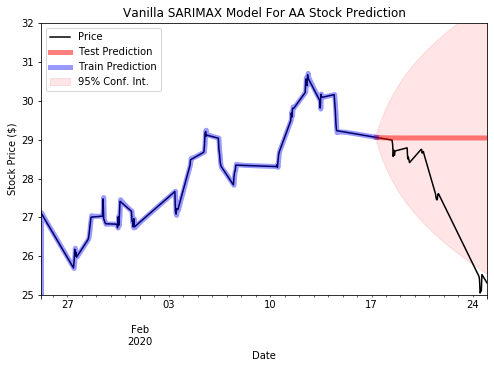

In [310]:
plt.rcParams["figure.figsize"] = [8, 5]
ax = stock_price_ts.plot(color='black')
pred_test.predicted_mean.plot(ax=ax, label='Test Prediction', alpha=.5, color='red', lw=5)
pred_train.predicted_mean.plot(ax=ax, label='Train Prediction', alpha=0.4, color='blue', lw=5)
ax.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='red', alpha=.1, label='95% Conf. Int.')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price ($)')
ax.set_ylim(25,32)
plt.legend(loc=2)
plt.title(f'Vanilla SARIMAX Model For AA Stock Prediction')
plt.show();

#### SARIMAX with Exogenous Variable (Twitter Sentiment)

In [299]:
train_data = stock_price_ts[:557]
test_data = stock_price_ts[557:]
train_exog = sent_scores_ts[:557]
test_exog = sent_scores_ts[557:]

In [316]:
# Instantiate vanilla SARIMAX model on stock ts

s_model = sm.tsa.SARIMAX(endog=train_data, exog=train_exog, order=(1,1,1))

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [317]:
# Fit model on training data

output2 = s_model.fit()

In [318]:
# Get predictions for train and test portions of data

pred_test = output2.get_prediction(start=stock_price_ts.index[556], end=stock_price_ts.index[740], dynamic=True, exog=test_exog)
pred_train = output2.get_prediction(start=stock_price_ts.index[0], end=stock_price_ts.index[556])

In [319]:
# Model prediction performance on train/test data

y_hat_test = pred_test.predicted_mean.values
y_hat_train = pred_train.predicted_mean.values

y_test = test_data.values.ravel()
y_train = train_data.values.ravel()

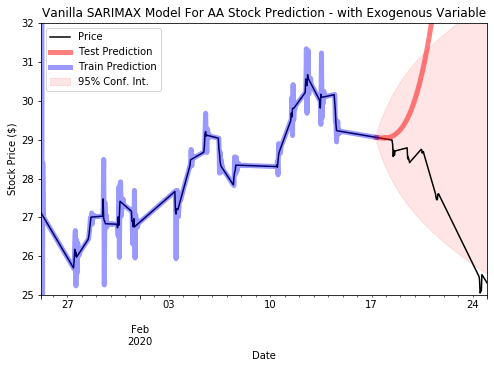

In [320]:
plt.rcParams["figure.figsize"] = [8, 5]
ax = stock_price_ts.plot(color='black')
pred_test.predicted_mean.plot(ax=ax, label='Test Prediction', alpha=.5, color='red', lw=5)
pred_train.predicted_mean.plot(ax=ax, label='Train Prediction', alpha=0.4, color='blue', lw=5)
ax.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='red', alpha=.1, label='95% Conf. Int.')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price ($)')
ax.set_ylim(25,32)
plt.legend(loc=2)
plt.title(f'Vanilla SARIMAX Model For AA Stock Prediction - with Exogenous Variable')
plt.show();